In [1]:
# %load ../standard_import.txt
# https://link.springer.com/content/pdf/bbm%3A978-1-4842-3913-1%2F1.pdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model 
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('seaborn-dark')

## Simple Linear Regression
---
Predicting a quantitative response Y on the basis of a single predictor X.
Mathematically, we can write this formula as $ sales \approx \beta_0 + \beta_1TV$. $\beta_0$ and $\beta_1$ are two unknown constants that represent the intercept or slope terms in the linear model. They are known as model coefficients or parameters.

**Assumptions of the Standard Linear Regression:**
1. **Linearity:** Y and X must have an approximately linear relationship.
2. **Independence:** Errors (residuals) $\varepsilon_i$ and $\varepsilon_j$ must be independent of one another for any $i \neq j$.
3. **Normality:** The errors (residuals) follow a Normal distribution with mean 0.
4. **Equality of Variances** (Homoscedasticity of errors): The errors (residuals) should have a roughly consistent pattern, regardless of the value of X. (There should be no discernable relationship between X and the residuals.)

The mnemonic **LINE** is a useful way to remember these four assumptions.

Lengthier discussions of the four main assumptions and how one can evaluate or test for each of these [can be found here](http://people.duke.edu/~rnau/testing.htm).

If all four assumptions are true, the following holds: 

### $$ Y_i \sim N(\beta_0 + \beta_1 X_i, \sigma) $$
**Steps:**
- [Estimate Coefficients through minimising the MSE](#minimizing-the-mse)
- [Assess Accuracy of Coefficient Estimates](#assess-accuracy-of-coefficient-estimates)
    - T-Test
- Assess accuracy of the model
    - Residual Standard Error
    - $R^2$

#### Import datasets

In [2]:
advertising = pd.read_csv('Data/Advertising.csv', usecols = [1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [3]:
credit = pd.read_csv('Data/Credit.csv', usecols = list(range(1,12)))
credit['Student2'] = credit.Student.map({'No': 0, 'Yes': 1})
credit.head()


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,0
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,0


In [4]:
auto = pd.read_csv('Data/Auto.csv', na_values = '?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## 3. 1 Simple Linear Regression
---
#### 3.1.1 Estimating the Coefficients

In [162]:
df = advertising.copy()
df = df[['TV','Sales']]
df.head()

,TV,Sales
0,230.1,22.1
1,44.5,10.4
2,17.2,9.3
3,151.5,18.5
4,180.8,12.9


#### Naive Basline Prediction
If we know very little about our data and can only use a single value, we can still predict the mean.

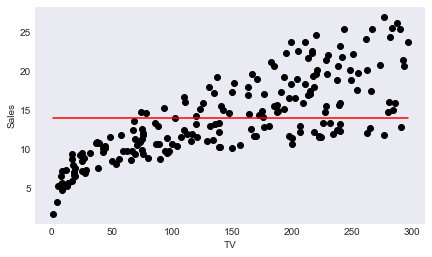

In [163]:
"""
Y = Sales
X = TV
Based on X, what is the estimated mean for Y?
"""
### Plot the data
# create a figure
fig = plt.figure(figsize=(7,4))
# get current axis of that figure
ax = plt.gca()

# plot a scatter plot on it with our data
ax.scatter(df.TV, df.Sales, c='k')
ax.plot((df['TV'].min(), df['TV'].max()),(np.mean(df['Sales']), np.mean(df['Sales'])), color='r')
ax.set_xlabel("TV")
ax.set_ylabel('Sales');

In [164]:
df['Mean_Sales_Yhat'] = df['Sales'].mean()
df.head()

,TV,Sales,Mean_Sales_Yhat
0,230.1,22.1,14.0225
1,44.5,10.4,14.0225
2,17.2,9.3,14.0225
3,151.5,18.5,14.0225
4,180.8,12.9,14.0225


<a id="finding-the-best-slope-and-intercept"></a>
## Finding the "best" slope and intercept

---

**1. If we want to find the "best" slope an intercept, we will need a criterion that defines what it means to be the "best".**

**2. We need to be able to numerically optimize (maximize or minimize) this criterion.**


<a id="residuals"></a>
### Residuals

The difference between the true value of $Y$ and the predicted value of $Y$ (denoted $\hat{Y}$, "Y-hat") is known as a "residual." We calculate a residual as $Y_i - \hat{Y}_i$ and denote each residual as $\varepsilon_i$.

**Note that the residual $\varepsilon_i$ is the same as the error in our modeled linear relationship!**

For every value of $i$ from 1 to $n$, we:
- have an observed $X_i$.
- have an observed $Y_i$.
- can calculate a predicted value $\hat{Y}_i$, which is equal to $f(X_i)$, where $f$ is our model.
- can calculate a residual $\varepsilon_i$, which is equal to $Y_i - \hat{Y}_i$.

<a id="residual-sum-of-squares-rss"></a>
### Residual sum of squares (RSS)/Sum of Squared Errors (SSE)

The most common way to define the "best fit line" is one that forces our residuals (a.k.a. errors) will be as close to zero as possible.

In fact, we seek to minimize the *sum of squared residuals* or [residual sum of squares (RSS)](https://en.wikipedia.org/wiki/Residual_sum_of_squares).

#### $$RSS = \sum_{i=1}^n (Y_i - \hat{Y}_i)^2 $$

This is also known as a **loss function**, where the "loss" here is the sum of squared residuals.

---


### Mean Squared Error (MSE)


#### $MSE(\mathbf{y},\hat{\mathbf{y}}) = \frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)^2$

Goal: Get $MSE$ as close to 0 as possible.

Pros: 
- Very common; part of other calculations.
- Represents average distance squared from the predicted value.

Cons: 
- Can be heavily affected by outliers.
- Not in the original units of $Y$.
- Depends on scale of $Y$. (i.e. housing prices vs. GPA)

---

### Root Mean Squared Error (RMSE)

#### $RMSE(\mathbf{y},\hat{\mathbf{y}}) = \sqrt{\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)^2}$

Goal: Get $RMSE$ as close to 0 as possible.

Pros: 
- Pretty common; part of other calculations.
- Represents (approximately) average distance from the predicted value.
- In the original units of $Y$.

Cons: 
- Can be heavily affected by outliers.
- Depends on scale of $Y$. (i.e. housing prices vs. GPA)

---

### Coefficient of Determination, $R^2$


#### $R^2 = \frac{\text{Explained variance}}{\text{Total variance}} = 1 - \frac{\sum_{i=1}^n(y_i - \hat{y}_i)^2}{\sum_{i=1}^n(y_i - \bar{y})^2}$

Goal: Get $R^2$ as close to 1 as possible.

> - score = 0: Model explains none of the variability of the response data around its mean.
> - score = 1: Model explains all the variability of the response data around its mean.

Pros:
- Easy interpretation. "An $R^2$ value of 0.8 means that 80% of the variability in the data are explained by our model, relative to a model with no predictors."
- Common metric.
- Does not depend on the scale of $Y$.
- Works with more than just _linear_ regression.

Cons:
- As you add more variables, $R^2$ will never decrease (with linear regression). Adjusted R2 can handle this assumption better.

> Are low $R^2$ scores bad?
>
> I'm glad you asked!  Not everything in regression is about getting the best predictions.  In some fields, such as human behavior, you would expect to achieve scores much lower then 50%!  For inference, perhaps .3 is enough to measure an effect when reported reliably!  Yes, there is more to machine learning than prediction.  Inference can be the goal as well!

[Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)

Remember our naive predictions?

In [165]:
# Calculate Sum of Squared Errors (SSE)/ Residual Sum of Squares (RSS)
np.sum(np.square(df['Sales'] - df['Mean_Sales_Yhat']))

5417.14875

In [166]:
# Calculate Mean Sum of Squared Errors (MSE)
np.mean(np.square(df['Sales'] - df['Mean_Sales_Yhat']))

27.085743750000002

In [167]:
# Calculate Root Mean Sum of Squared Errors
(np.mean(np.square(df['Sales'] - df['Mean_Sales_Yhat']))) ** 0.5

5.204396578855228

<a id="minimizing-the-mse"></a>
### Minimizing the MSE

For simple linear regression [we can derive the intercept and slope that minimize the RSS algebraically](https://en.wikipedia.org/wiki/Simple_linear_regression#Fitting_the_regression_line). 

Given variables:
- $\bar{y}$ : the sample mean of observed values $Y$
- $\bar{x}$ : the sample mean of observed values $X$
- $s_Y$ : the sample standard deviation of observed values $Y$
- $s_X$ : the sample standard deviation of observed values $X$
- $r_{XY}$ : the sample Pearson correlation coefficient between observed $X$ and $Y$

The equations for the intercept and slope that minimize the RSS is:

### $$ \hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x} \\
\hat{\beta}_1 = r_{XY} \frac{s_Y}{s_X}$$

Our simple linear regression is an **estimator of the expected value (mean) of $Y$**.

> **Note:** Estimators are mathematical functions or formulas that yield an *estimate*. For example, an estimator might be the sample mean whereas the estimate is the value of the sample mean from our data set.

In [168]:
y_bar = df['Sales'].mean() # Sample mean of observed values of Y
x_bar = df['TV'].mean() # Sample mean of observed values of x
std_y = np.std(df['Sales'], ddof = 1)
std_x = np.std(df['TV'], ddof = 1)
r_xy = df.corr().loc['TV','Sales']
beta_1 = r_xy*(std_y/std_x)
beta_0 = y_bar - beta_1*x_bar

In [169]:
df['Linear_Yhat'] = beta_0 + beta_1 * df['TV']

In [170]:
np.square(df['Sales'] - df['Linear_Yhat']).mean()

10.512652915656757

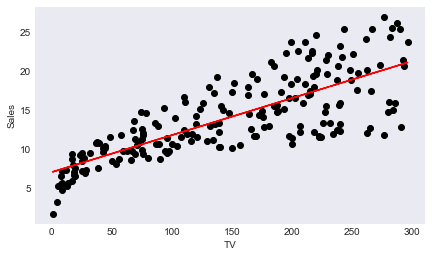

In [171]:
# create a figure
fig = plt.figure(figsize=(7,4))
# get the axis of that figure
ax = plt.gca()

# plot a scatter plot on it with our data
ax.scatter(df.TV, df.Sales, c='k')
ax.plot(df['TV'], df['Linear_Yhat'], color='r')
ax.set_xlabel("TV")
ax.set_ylabel('Sales');

**How does our new MSE compare to our old MSE?**

If you noticed, our MSE is much smaller now. 10.51 AS compared to 27.085.

We can even plot our residuals!

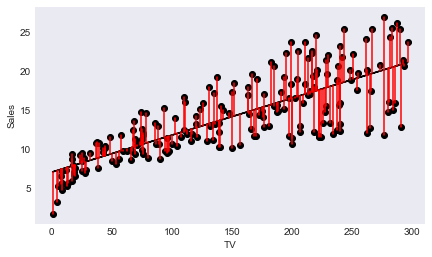

In [15]:
# create a figure
fig = plt.figure(figsize=(7,4))
##fig.set_figheight(8)
#fig.set_figwidth(15)

# get the axis
ax = fig.gca()

# plot it
ax.scatter(x=df['TV'], y=df['Sales'], c='k')
ax.plot(df['TV'], df['Linear_Yhat'], color='k')
ax.set_xlabel("TV")
ax.set_ylabel('Sales');

# iterate over predictions
for _, row in df.iterrows():
    plt.plot((row['TV'], row['TV']), (row['Sales'], row['Linear_Yhat']), 'r-')

<a id="interpretation-of-slr"></a>
## Interpretation of SLR

---

Suppose I believe that commute time, my $Y$, is best modeled as a linear function of the number of Metro stops I take. Then, my model is:
### $$ [commute] = \beta_0 + \beta_1 [Metro\_stops] $$

I want to estimate this model from our data. I gather data over a long period of time and put it into a Pandas dataframe with a column for commute time and a column for number of Metro stops. Then, my estimate of the true model is:

### $$ \hat{[commute]} = \hat{\beta}_0 + \hat{\beta}_1 [Metro\_stops] $$

Let's say that $\hat{\beta}_0$ is 5 and $\hat{\beta}_1$ is 3.
- I interpret $\hat{\beta}_1$ by saying "As the number of Metro stops increases by 1, I expect commute time to increase by three minutes."
- I interpret $\hat{\beta}_0$ by saying "If someone travels zero stops on the Metro, I expect commute time to be five minutes."

The simple linear regression estimators described above have really nice properties:

1. They are unbiased. (a.k.a. the statistics will on average equal the true parameter value)
2. Among all unbiased estimators, the estimators above have the smallest possible variance.
3. They are consistent. (a.k.a. as your sample size n goes to infinity, the statistic converges to the true parameter value)

**However, these are just mathematical properties.** They do not take into account real-world situations. For example, suppose I want to use a SLR model to predict my commute time and I get the model:

    [commute time] = 8 * [number of Metro stops] - 10

In this case, my commute time is estimated to be negative if I go zero stops or one stop on the Metro. If I were to interpret my intercept, I might say "If I travel zero Metro stops on my way to work, I expect to commute -10 minutes." Of course, this is nonsense; you can't have a negative commute time!

**What this means:** 

When building a model, make sure your model makes sense! You are responsible for the interpretation of the model. All the computer will do is optimize. You may not do anything wrong when you fit a model (and you won't get an error!), but make a note that there are shortcomings to the framework.

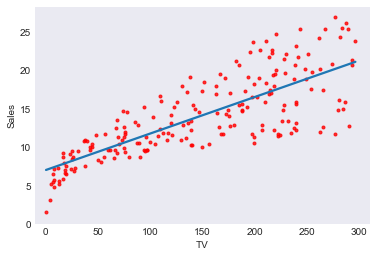

In [16]:
sns.regplot(df.TV, df.Sales, order =1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(ymin=0);

##### Build a Function that will take it two lists, Y and X and return the intercept and the slope.

In [176]:
# Get the optimal slope and y intercept.
import scipy.stats
def lin_reg(x,y):
    # Using other libraries for standard deviation and the Pearson correlation coefficient.
    # Note that in SLR, the correlation coefficient multiplied by the standard
    # deviation of y divided by standard deviation of x is the optimal slope.
    beta_1 = (scipy.stats.pearsonr(x,y)[0])*(np.std(y)/np.std(x))
    
    # The Pearson correlation coefficient returns a tuple, so it needs to be sliced/indexed.
    # The optimal beta is found by: mean(y) - b1 * mean(x).
    beta_0 = np.mean(y)-(beta_1*np.mean(x)) 
    
    return beta_0, beta_1

In [177]:
X = advertising['TV'].values
y = advertising['Sales'].values
beta0, beta1 = lin_reg(X,y)

#Print the optimal values.
print('The Optimal Y Intercept is ', beta0)
print('The Optimal slope is ', beta1)

The Optimal Y Intercept is  7.032593549127696
The Optimal slope is  0.04753664043301974


In [17]:
regr = sklearn.linear_model.LinearRegression()
X = scale(advertising.TV, with_mean = True, with_std = False).reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

print("An additional $1000 spent on TV advertising is associated with selling approximately 47.5 additional units of the product.")


14.0225
[0.04753664]
An additional $1000 spent on TV advertising is associated with selling approximately 47.5 additional units of the product.


In [18]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

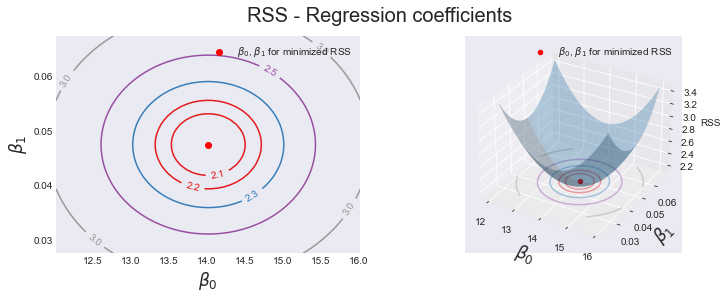

In [19]:
fig = plt.figure(figsize=(12,4))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

<a id="assess-accuracy-of-coefficient-estimates"></a>
#### 3.1.2 Assessing the Accuracy of the Coefficient Estimates
If _f_ is to be approximated by a linear function, we can write this relationship as: $$ Y = \beta_0 + \beta_1 + \epsilon $$

Here, $\beta_0$ is the intercept term - that is, the expected value of $Y$ when $X$ = 0 and $\beta_1$ is the slope - the average increase n Y associated with a one unit increase in X.

A natural question then follows, how accurate is the sample mean $\hat\mu$ as an estimate of $\mu$?
Answer: By computing the _standard error_ of $\hat\mu$, written as SE($\hat\mu$). We then have the well-known formula:
$$ Var(\hat\mu) = SE(\hat\mu)^2 = \frac{\sigma}{n} $$


- Standard Errors can be used to compute _confidence intervals_
    - For example, for each $1000 increase in Television Advertising, there will be an average increase in sales of between 42 and 53.
- Standard Errors can be used to perform _hypothesis tests_ on coefficients.

The null hypothesis that there is no relationship between $X$ and $Y$ versus the alternative.
$h_0: \beta_1 = 0\\h_1: \beta_1 \neq 0$

Then, we compute a _t-statistic_ given by $t = \frac{\hat\beta_1 - 0}{SE(\hat\beta_1)}$, which measures the number of standard deviations that $\hat\beta_1$ is away from 0. Roughly speaking, we interpret the p-values as follows: a small p-value indicates that it is unlikely to observe such a substantial association between predictor and response due to chance, in the absence of any real association between predictor and response. Hence, if we see a small _p-value_, we can infer that there is an association between predictor and response and we reject the null hypothesis - we declare a relationship to exist between $X$ and $Y$. Typically, _p-value_ cutoffs for rejecting null hypothesis are 5% of 1%. As shown below, coefficients for $\beta_0$ (intercept) and $\beta_1$ are very large compared to their standard errors, so t-statistics are very large, the probabilities of seeing such values if $h_0$ is true is virtually zero. Hence, we can conclude that $\beta_0 \neq 0$ and $\beta_1 \neq 0$.

In [20]:
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


#### 3.1.3 Assessing the Accuracy of the Coefficient Estimates

Once we have rejected the null hypothesis in favour of the alternative, it is natural to want to quantify the extent to which the model fits the data. The quality of linear regression fit is assessed by using two related quantities: (i) _residual standard error_ (ii) $R^2$.

More information aout the least squares model:

|Quantity|Value|
|---|---|
|Residual Standard Error|3.26|
|$R^2$|0.612|
|F-statistic|312.1|

Roughly speaking, **RSE** measures the average amount that the average will deviate from the true regression line. It is computed against the formula. $$RSE =  \sqrt{\frac{1 * RSS}{n-2}}  = \sqrt{\frac{1 * \sum_{i=1}^n (Y_i - \hat{Y}_i)^2}{n-2}} $$


We see from the linear regression output that the RSE is 3.26. In other words, actual sales in in each market deviate from the true regression line by approximately 3260 units on average. In the advertising data set, the mean value of sales over all markets is about 14000 units and so the percentage error is 3260/14000 = 23%.Unlike RMSE, the relative squared error (RSE) can be compared between models whose errors are measured in the different units.

Unlike RMSE, the relative squared error (RSE) can be compared between models whose errors are measured in the different units.

---

The *$R^2$* takes the form of a proportion - the proportion of variance explained - and so it always takes the value between 0 and 1 and is independent of the scale of $Y$.

$$ R^2 = {\frac{TSS - RSS}{TSS}} = 1 - {\frac{RSS}{TSS}}$$

TSS measures the total variance in the response Y, and can be thought of as the amount of variability inherent in the response before a regression is performed. In contrast, RSS measures the amount of variablility that is left unexplained after performing the regression. Hence, TSS - RSS measures the amount of variability in the response that is explained (or removed) by performing the regression, and $R^2$ meqasures the proportion of variability in Y that can be explained by X. For example, in table $R^2$ of model is 0.61 so just under two-thirds of the variability in _sales_ is explained by the linear regression on _TV_.




## 3. 2 Multiple Linear Regression

In [21]:
df = advertising.copy()

<a id='slr-to-mlr'></a>

## From simple linear regression (SLR) to multiple linear regression (MLR)

---

The TL;DR of multiple linear regression:

> Instead of using just one predictor to estimate a continuous target, we build a model with multiple predictor variables. You will be using MLR way more than SLR going forward.

These variables will be represented as columns in a matrix (often a pandas dataframe).


<a id='assumptions'></a>

## Assumptions of MLR

---

Like SLR, there are assumptions associated with MLR. Luckily, they're quite similar to the SLR assumptions.

1. **Linearity:** $Y$ must have an approximately linear relationship with each independent $X_i$.
2. **Independence:** Errors (residuals) $\varepsilon_i$ and $\varepsilon_j$ must be independent of one another for any $i \ne j$.
3. **Normality:** The errors (residuals) follow a Normal distribution with mean 0.
4. **Equality of Variances**: The errors (residuals) should have a roughly consistent pattern, regardless of the value of the $X_i$ predictors. (There should be no discernable relationship between the $X$ predictors and the residuals.)
5. **Independence of Predictors**: The independent variables $X_i$ and $X_j$ must be independent of one another for any $i \ne j$.

The mnemonic LINEI is a useful way to remember these five assumptions.

<a id='fit-mlr'></a>

## Fitting a multiple linear regression

---

The formula for computing the $\beta$ values in multiple regression is best done using linear algebra. We will cover the derivation, but for more depth  [these slides are a great resource](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf).

$X$ is now a _matrix_ of predictors $x_1$ through $x_i$ (with each column a predictor), and $y$ is the target vector we are seeking to estimate. There is still only 1 *estimated* variable!

### $$ \hat{y} = X \beta$$

**Note:** $\beta$ in the formula above is a *vector* of coefficients now, rather than a single value.

In different notation we could write $\hat{y}$ calculated with:

### $$ \hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n $$

---

<a id='mlr-beta-derivation'></a>

### Deriving the $\beta$ coefficients

$\beta$ is solved with the linear algebra formula:

### $$ \beta = (X^TX)^{-1}X^Ty $$

Where $X'$ is the transposed matrix of original matrix $X$ and $(X^TX)^-1$ is the inverted matrix of $X^TX$.

<a id='code-mlr'></a>

### Code a MLR

**First, we need to create the "design matrix" of our predictors.**

The first column will be a column of all 1s (the intercept) and the other columns will be `TV`, `Radio`, `Newspaper`

This is easiest to do with pandas: add a column for the intercept first, then extract the matrix using with `.values`.

In [22]:
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [23]:
X = df.loc[:,['TV','Radio','Newspaper']]
X['intercept'] = 1
X = X.values
print(X[0:3,:])

[[230.1  37.8  69.2   1. ]
 [ 44.5  39.3  45.1   1. ]
 [ 17.2  45.9  69.3   1. ]]


### Solve for the beta coefficients

We are still predicting `Sales`. Implement the linear algebra equation to solve for the beta coefficients. 

### $$ \beta = (X^TX)^{-1}X^Ty $$

**Tips:**

The transpose of a matrix is calculated by appending `.T` to the matrix:

    X.T

Matrices multipled in the formula should be done with the "dot product":

    np.dot(mat1, mat2)

Inverting a matrix is done using:

    np.linalg.inv()

In [24]:
sales = df['Sales'].values
beta_vec = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), sales)
print(beta_vec)

[ 4.57646455e-02  1.88530017e-01 -1.03749304e-03  2.93888937e+00]


**Confirm that these betas are the same as the ones using `sklearn.linear_model.LinearRegression`**

```python
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=False)
linreg.fit(X, price)

print linreg.coef_
```

In [25]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=False)
linreg.fit(X, sales)
print(linreg.coef_)

[ 4.57646455e-02  1.88530017e-01 -1.03749304e-03  2.93888937e+00]


## Using SKLEARN for MLR

In [26]:
# Easier by putting in pandas
df = df.loc[:,['TV','Radio','Newspaper']]
target = pd.DataFrame(sales).rename({0 : 'Sales'}, axis='columns')
print(target.shape)
print(df.shape)
df.head()
# Row 0 of our df is 230.1, 37.8, 69.2 which corresponds to our target of 22.1


(200, 1)
(200, 3)


,TV,Radio,Newspaper
0,230.1,37.8,69.2
1,44.5,39.3,45.1
2,17.2,45.9,69.3
3,151.5,41.3,58.5
4,180.8,10.8,58.4


In [27]:
target.head()

,Sales
0,22.1
1,10.4
2,9.3
3,18.5
4,12.9




These two separate datasets (a matrix/dataframe, and a vector), are what we will use in the `.fit(predictors, target)` function in `sklearn`'s models.  

- The training data is 2D with dimensions: `n_samples x n_features`
- The response is 1D with dimensions: `n_samples`, matching the `n_samples` of the training data.

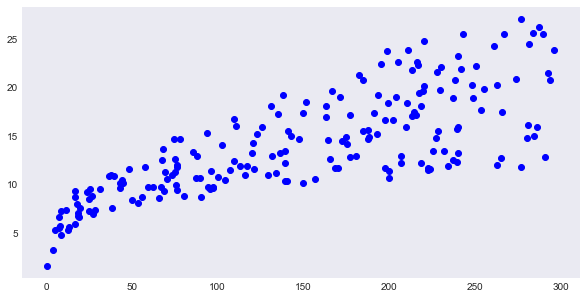

In [28]:
# create a figure
fig = plt.figure(figsize=(10,5))
# get the axis of that figure
ax = plt.gca()

# plot a scatter plot on it with our data
ax.scatter(df['TV'], target, c='b');

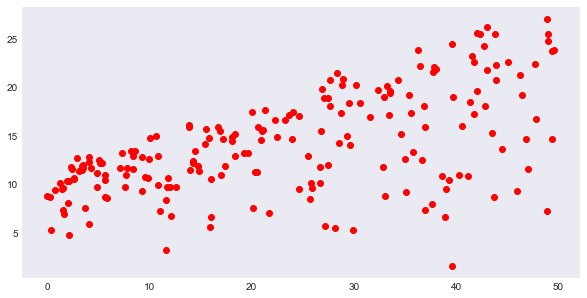

In [29]:
# create a figure
fig = plt.figure(figsize=(10,5))
# get the axis of that figure
ax = plt.gca()

# plot a scatter plot on it with our data
ax.scatter(df['Radio'], target, c='r');

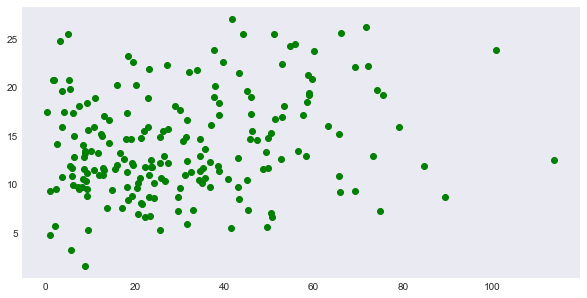

In [30]:
# create a figure
fig = plt.figure(figsize=(10,5))
# get the axis of that figure
ax = plt.gca()

# plot a scatter plot on it with our data
ax.scatter(df['Newspaper'], target, c='g');

In [31]:
target.shape

(200, 1)

In [32]:
df.shape

(200, 3)

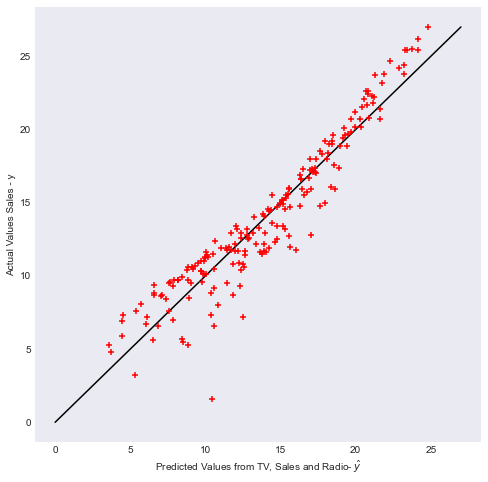

In [33]:
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
lm = linear_model.LinearRegression()

X = df[['TV','Radio','Newspaper']].values # array
y = target # dataframe

model = lm.fit(X,y)

predictions = model.predict(X)
score = model.score(X, y)

# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from TV, Sales and Radio- $\hat{y}$")
plt.ylabel("Actual Values Sales - y")

plt.plot([0, np.max(y)], [0, np.max(y)], c = 'k')

plt.show()


In [34]:
print(model.coef_)

[[ 0.04576465  0.18853002 -0.00103749]]


In [35]:
# For a $1000 increase in TV avertising(holding constant other variables), there is a 45 units increase in sales
# For a $1000 increase in Radio advetising (holding constant other variables), there is a 189 units increase in sales
# For a $1000 increase in Newspaper advertising (holding constant other variables), there is a 1 unit decrease in sales

## Using Statsmodels for MLR


## Fitting a linear regression using `statsmodels`

---

Now we will fit the linear regression model predicting the target from `RM` and `LSTAT`, but this time using `statsmodels`.

The format looks like:

```python
import statsmodels.api as sm

X = df[['TV','Radio','Newspaper']].values
# manually add the intercept column:
X = sm.add_constant(X)
y = target

model = sm.OLS(y, X)
model = model.fit()
predictions = model.predict()
```

First we load the statsmodels api module, which contains the ordinary least squares `OLS` model class. The statsmodels process is slightly different:
- We manually make a new column for the intercept in our design matrix $X$.
- The $y$ target variable comes before the $X$ predictor
- The data is provided during the instantiation of the model object, then fit is called without the data.

**Fit the model using statsmodels.**

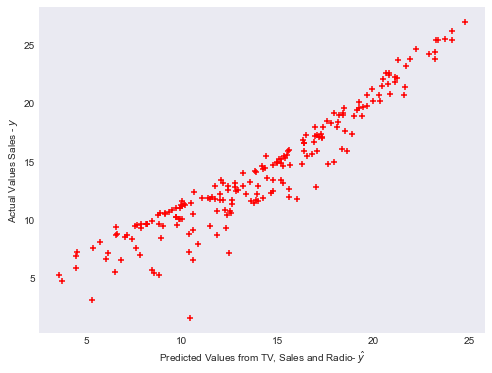

MSE: 2.784126314510936


In [36]:
import statsmodels.api as sm

X = df[['TV','Radio','Newspaper']].values # array
X = sm.add_constant(X)
y = target # dataframe

# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
model = sm.OLS(y, X)
model = model.fit()
predictions = model.predict(X)

# Plot the model
plt.figure(figsize=(8,6))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from TV, Sales and Radio- $\hat{y}$")
plt.ylabel("Actual Values Sales - $y$")
plt.show()

print("MSE:", mean_squared_error(y, predictions))

##### Interpret Model Summary
---
As we are testing the model at 95% confidence interval and the p-value for $x3$ is > 0.05, you fail to reject the null hypothesis that there is no relationship between the x variable and the y variable. Hence, it is irrelevant in the model - the coefficient estimate for newspaper in the multiple regression model is close to 0 and the corresponding p-value is not significant, with a value of 0.86. This is further highlighted in the cell below showing the correlation matrix for the three predictor variables and response variables. This reveals a tendency to spend more on newspaper advertising in markets where more is spent on radio advertising.

**Some important Questions:**
- Is at least one of the predictors $X_1$, $X_2$, $X_3$ useful in predicting $Y$?

Recall that in the simple regression setting, in order to determine whether there is a relationship between response and predictor, we can simply check whether $\beta_0$ = 0. However, in the multiple regression setting with p predictors (here 3 predictors), we need to ask whether all regression coefficients are 0 i.e. whether $h_0: \beta_1 = \beta_2 = \beta_3 = 0\\h_1: atleast 1 \beta_j = 0$ The hypothesis test performed by computing the _F-statistic_. In this example, the F-statistic is 570 and this is far larger than 1, it provides compelling evidence against the null hypothesis $h_0$. In other words, the large F-statistic suggests that atleast one of the advertising media must be related to sales. The approach of using an F-statistic to test for any association between the predictors and the response works when the number of predictors (p) is relatively small and certainly small compared to (n) number of observations.

- Do all predictors help to explain Y (Sales) or is it only that a subset of the predictors are useful?

The task of determining which predictors are associated with the response in order to fit a single model involving those predictors is referred to as _variable selection_. Ideally, we would like to perform variable selection by trying out a lot of models. if p=2, then we can try out $p^2$ = 4 models (i. model with no variables ii. model with only X1 iii. model with only X2 iv. model containing X1 and X2. However, if number of predictors p = 30 then there are 1,073741824 models which is not feasible. We then need an automated and efficient approach for this problem through 3 different classical approaches (Forward Selection, Backward Selection, Mixed Selection).

- How well does the model fit the data?

$R^2$ is 0.897 so 89% of the variability in _sales_ is explained by the multiple linear regression on _TV_, _Radio_, _Newspaper_. Notice, there is a small increase in $R^2$ if we include newspaper advertising even though we can see that the p-value for newspaper advertising is not significant. Meaning the $R^2$ will always increase when more variables added to the model even if variables weakly associated to the response. 


- Given a set of predictor values, what response values should we predict, and how accurate is our prediction

The inaccuraccy in the coefficient estimates is related to the reducible error from chapter 2. We can compute a confidence interval in order to determine how close Y_hat will be to _f(x)_. We use a _confidence interval_ to quantify the uncertainty surrounding the average sales. For example, given that 100,000 is spent on TV advertising in each city, the 95% confidence interval is [10,985,11,528].

In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sat, 09 Oct 2021   Prob (F-statistic):           1.58e-96
Time:                        15:00:02   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.000       2.324       3.554
x1             0.0458      0.001     32.809      0.000       0.043       0.049
x2             0.1885      0.009     21.893      0.000       0.172       0.206
x3            -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Newspaper,Radio,TV
Newspaper,1.000000,0.354104,0.056648
Radio,0.354104,1.000000,0.054809
TV,0.056648,0.054809,1.000000


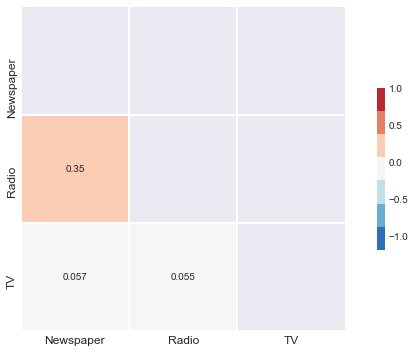

In [38]:
df= df[df.columns.sort_values()]

# plot heatmap
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(9, 5))
sns.heatmap(df.corr(),
            mask = mask,
            square=True,
            vmin = -1.2,
            vmax = 1,
            linewidth=0.1,
            cbar_kws = {'shrink':0.5},
            cmap=sns.color_palette("RdBu_r", 7),
           annot = True)
ax.tick_params(labelsize=12)
plt.tight_layout()

## Show table of correlation
display(df.corr())

_____

# End to end with SK LEARN

In [39]:
df = advertising.copy()

In [40]:
X = df[['TV','Radio','Newspaper']]
Y = df['Sales']

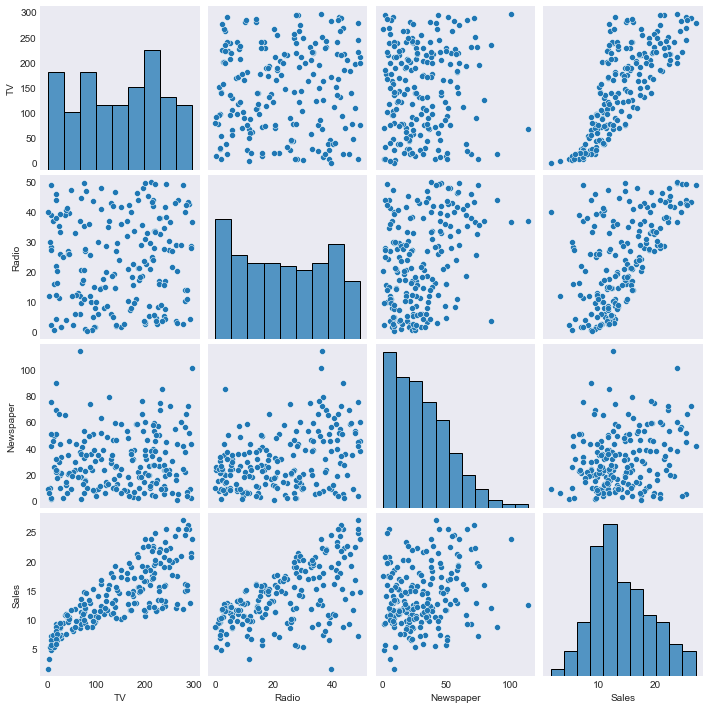

In [41]:
sns.pairplot(df)

### 1. Split Data into Train and Test Split

<a name="train-test-split"></a>
#### Train/Test Split and Model Validation

---

So far we've focused on fitting the best model to our data. But is this the best model for our sample data or the best model overall? How do we know?

In practice we need to validate our model's ability to generalize to new data. One popular method for performing model validation is by splitting our data into subsets: data on which we *train* our model and data on which we *test* our model.

The most basic type of "hold-out" validation is called **train/test split**. We split our data into two pieces:

> **"A Training Set":** The subset of the data on which we fit our model.

> **"A Testing Set":** The subset of the data on which we evaluate the quality of our predictions.


**Train/Test Split Benefits:**

- Testing data can represent "future" data; for prediction-oriented models, it's critical to ensure that a model that is performing well on current data will likely perform well on future data.
- It can help diagnose and avoid overfitting via model tuning.
- It can improve the quality of our predictions.

---
<a id='sklearn-tts'></a>

#### Scikit-Learn's `train_test_split` Function
---

Performing train/test splits using scikit-learn is easy — load the `train_test_split` function:

```python
from sklearn.model_selection import train_test_split
```

**Arguments**:
- *Arrays*: Any number of arrays/matrices to split up into training and testing sets (they should be the same length).
- `test_size`: An integer representing the exact size of the testing subset or a float for a percentage.
- `train_size`: Alternatively, you can specify the training size.
- `stratify`: Supply a vector to stratify the splitting (by more important classification tasks).
- `random_state`: a numerical seed for randomly splitting your data with reproducibility

**Perform a split of our `X` and `y`.**

In [42]:
# Split the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

# Ensure training dataset has only 70% of original X data
print(X_train.shape[0] / X.shape[0])

# Ensure testing dataset has only 30% of original X data
print(X_test.shape[0] / X.shape[0])

0.7
0.3


### 2. Initialise model and fit model onto the training data

In [43]:
#2 Initialise the model
mlr = LinearRegression()

# 3. Fit the model on the training data (training model)
mlr.fit(X_train, Y_train)
print("Intercept: ", mlr.intercept_)
print("Coefficients:")
list(zip(X, mlr.coef_))

# For a $1000 increase in TV avertising(holding constant other variables), there is a 46 units increase in sales
# For a $1000 increase in Radio advetising (holding constant other variables), there is a 183 units increase in sales
# For a $1000 increase in Newspaper advertising (holding constant other variables), there is a 2 unit increase in sales

Intercept:  2.6713663237478116
Coefficients:


[('TV', 0.04726416193845512),
 ('Radio', 0.18432425696675886),
 ('Newspaper', 0.005185467761289225)]

### 3. Make predictions from own input or test set

#### - Predict from Own input 

In [44]:
mlr.predict([[230, 37.8, 80]])

array([20.9244179])

**How much would my sales be if I spent 250 on TV, 23 on Radio and 80 on Newspaper advertising?**

Ans: `mlr.predict([[250, 23, 80]])`

In [45]:
pd.DataFrame({'Sales predictions based on my input for TV, Radio, Newspaper': mlr.predict([[250, 23, 80]])})

,"Sales predictions based on my input for TV, Radio, Newspaper"
0,19.141702


In [46]:
print(f"These are the number of units my model is predicting that I sell if I spend $250 on TV Advertising, $23 on Radio Advertising and $80 on Newspaper advertising: {mlr.predict([[250,23, 80]])}") 
"""
To show how this works his practice by using coefficients from above --> 
"""
print(f"I am using the formula of b_0 + b_1(TV) + b_2(Radio) + b_3(Newspaper) from my intercept and coefficients:{3.0515032475046997 +  0.04554662911179826 * 250 + 0.18289400293036023 * 23 +  -0.0021476480012402044 * 80}")

These are the number of units my model is predicting that I sell if I spend $250 on TV Advertising, $23 on Radio Advertising and $80 on Newspaper advertising: [19.14170214]
I am using the formula of b_0 + b_1(TV) + b_2(Radio) + b_3(Newspaper) from my intercept and coefficients:18.472910752753332


#### - Predict on test data

In [47]:
# Predict values on the testing data which I had split earlier with train-test-split
pred_Y = mlr.predict(X_test)
print("Prediction for test set: {}".format(pred_Y)) # This will return a list (np array of predictions)

Prediction for test set: [ 5.90686961 15.27168049 20.5625547  20.77517868  7.39081441 10.14066784
 21.21973888 14.31989717  6.48320815  6.50965841  8.03330331 10.12082587
 16.90663617 10.38459851 12.14410339 10.60775712 16.98026953 21.66324003
  7.49097304  9.81191928 16.29620131  4.47072818 19.72947587 12.25242942
 15.84336602 15.71479545  6.65311511 13.51026009 12.70392086  6.50655262
 10.66118751 10.19118596 17.21086413 16.71271369 15.14805193 11.55674976
 17.92266083  9.20486873 12.02542545 14.82124244 20.79099701 21.97262694
 13.78181011 19.01783558 19.46875632 10.59521653  7.11964669 10.26030524
 11.98868151 20.4786492   8.06884153 11.8704969   8.70597218 23.89464815
 20.27949469  9.7897313  12.86556826  6.99009644 10.55999299 13.6935728 ]


In [48]:
# Check out difference between what my model predicted on testing data and also what really happened!
actual_and_predicted_diff = pd.DataFrame({'Actual Sales':Y_test, 'Predicted Sales': pred_Y})
actual_and_predicted_diff.head()

,Actual Sales,Predicted Sales
189,6.7,5.906870
199,13.4,15.271680
39,21.5,20.562555
185,22.6,20.775179
172,7.6,7.390814


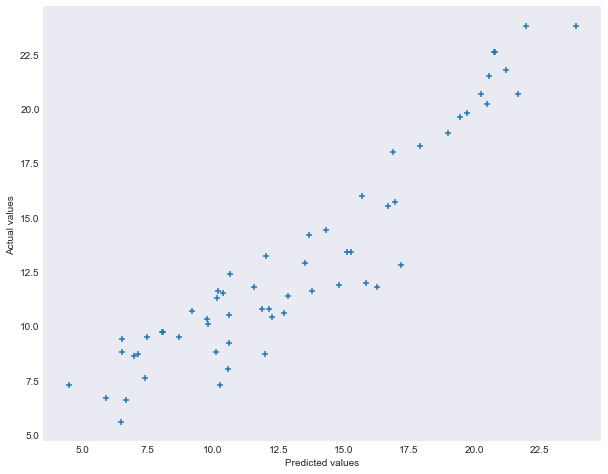

In [49]:
# Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter(pred_Y, Y_test, marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values');



##### Residuals
---

Recall the formula for linear regression:

#### $ Y = \beta_0 + \beta_1 X_1 + \varepsilon$

It's important to remember that $\varepsilon$ represents the irreducible error. Irreducible error is the error we'll never be able to solve. $\varepsilon$ has a few important properties that we want our residuals to mimic:

1. It is random (ie no discernible pattern)
2. It has a mean of zero. Stated differently, our model should be just as likely to undershoot a prediction as it is to overshoot.

In the cells below, do the following:

1. Create your residuals: `y - y_hat`
2. Calculate the mean of your residuals

In [50]:
Y_test_df = Y_test.to_numpy() # convert dataframe to numpy (this is our y)
print(Y_test_df)

[ 6.7 13.4 21.5 22.6  7.6 11.3 21.8 14.4  5.6  8.8  9.7  8.8 18.  11.5
 10.8  9.2 15.7 20.7  9.5 10.1 11.8  7.3 19.8 10.4 12.  16.   6.6 12.9
 10.6  9.4 12.4 11.6 12.8 15.5 13.4 11.8 18.3 10.7 13.2 11.9 22.6 23.8
 11.6 18.9 19.6 10.5  8.7  7.3  8.7 20.2  9.7 10.8  9.5 23.8 20.7 10.3
 11.4  8.6  8.  14.2]


In [51]:
pred_Y

array([ 5.90686961, 15.27168049, 20.5625547 , 20.77517868,  7.39081441,
       10.14066784, 21.21973888, 14.31989717,  6.48320815,  6.50965841,
        8.03330331, 10.12082587, 16.90663617, 10.38459851, 12.14410339,
       10.60775712, 16.98026953, 21.66324003,  7.49097304,  9.81191928,
       16.29620131,  4.47072818, 19.72947587, 12.25242942, 15.84336602,
       15.71479545,  6.65311511, 13.51026009, 12.70392086,  6.50655262,
       10.66118751, 10.19118596, 17.21086413, 16.71271369, 15.14805193,
       11.55674976, 17.92266083,  9.20486873, 12.02542545, 14.82124244,
       20.79099701, 21.97262694, 13.78181011, 19.01783558, 19.46875632,
       10.59521653,  7.11964669, 10.26030524, 11.98868151, 20.4786492 ,
        8.06884153, 11.8704969 ,  8.70597218, 23.89464815, 20.27949469,
        9.7897313 , 12.86556826,  6.99009644, 10.55999299, 13.6935728 ])

In [52]:
residuals = Y_test_df - pred_Y
residuals

array([ 0.79313039, -1.87168049,  0.9374453 ,  1.82482132,  0.20918559,
        1.15933216,  0.58026112,  0.08010283, -0.88320815,  2.29034159,
        1.66669669, -1.32082587,  1.09336383,  1.11540149, -1.34410339,
       -1.40775712, -1.28026953, -0.96324003,  2.00902696,  0.28808072,
       -4.49620131,  2.82927182,  0.07052413, -1.85242942, -3.84336602,
        0.28520455, -0.05311511, -0.61026009, -2.10392086,  2.89344738,
        1.73881249,  1.40881404, -4.41086413, -1.21271369, -1.74805193,
        0.24325024,  0.37733917,  1.49513127,  1.17457455, -2.92124244,
        1.80900299,  1.82737306, -2.18181011, -0.11783558,  0.13124368,
       -0.09521653,  1.58035331, -2.96030524, -3.28868151, -0.2786492 ,
        1.63115847, -1.0704969 ,  0.79402782, -0.09464815,  0.42050531,
        0.5102687 , -1.46556826,  1.60990356, -2.55999299,  0.5064272 ])

In [53]:
residuals = pd.DataFrame({'y_from_test_set':Y_test_df, 'y_prediction_based_on_model': pred_Y, 'residuals': residuals})
residuals.head()

,y_from_test_set,y_prediction_based_on_model,residuals
0,6.7,5.906870,0.793130
1,13.4,15.271680,-1.871680
2,21.5,20.562555,0.937445
3,22.6,20.775179,1.824821
4,7.6,7.390814,0.209186


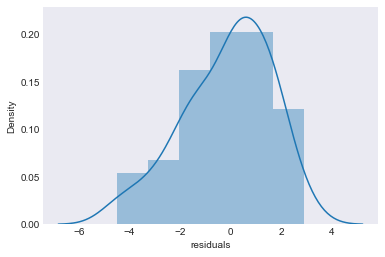

In [54]:
import seaborn as sns
sns.distplot(residuals.residuals);

### 4. Evaluate the model 

#### Model Evaluation
---

We need two scores to determine if our model is performing well, or experiencing high bias/variance. Use the `.score()` method on **both** the training set (`X_train`, `y_train`) and the test set (`X_test`, `y_test`).

```python
model.score(X_train, y_train)
```

<a id='cross-val-k-fold'></a>

#### K-Fold Cross-Validation

---

K-fold cross-validation takes the idea of a single train/test split and expands it to *multiple tests* across different train/test splits of your data.

For example, if you determine your training set will contain 80 percent of the data and your testing set will contain the other 20 percent, you could have five different 80/20 splits in which the test set in each is a different set of observations. We have:
- Five (K=5) training sets.
- Five (K=5) corresponding testing sets.

**K-fold cross-validation builds K models — one for each train/test pair — and evaluates those models on each respective test set.**

##### K-Fold Cross-Validation Visually

<img src="https://snag.gy/o1lLcw.jpg?convert_to_webp=true" width="500">

---

Cross-validation helps us understand how a model parameterization may perform in a variety of cases. The k-fold cross-validation procedure can be described in pseudocode:

```
set k
create k groups of rows in data

for group i in k row groups:
    test data is data[group i]
    train data is data[all groups not i]
    
    fit model on train data
    
    score model on test data
    
evaluate mean of k model scores
evaluate variance of k model scores
```

Odd case No. 1:
> **When K=2**: This is equivalent to performing ***two*** mirror image 50-50 train/test splits.

Odd case No. 2:
> **When K=number of rows**: This is known as "leave-one-out cross-validation," or LOOCV. A model is built on all but one row and tested on the single excluded observation.

In [55]:
# Training data r^2 score
print(mlr.score(X_train, Y_train))
print()
# Test data r^2 score
print(mlr.score(X_test,Y_test))


0.9030538335061812

0.8707311045412675


##### K-Folds Cross Validation in `sklearn`
---

Now let's try out k-fold cross-validation. Again, scikit-learn provides useful functions to do the heavy lifting. 

The function `cross_val_score` returns the $R^2$ for each testing set. 

In the cells below, score your training set (`X_train`, `y_train`) using `cross_val_score`.


In [56]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlr, X_train, Y_train, cv = 5).mean()

0.9019778881233584

In [57]:
from sklearn import metrics
mean_absolute_error = metrics.mean_absolute_error(Y_test, pred_Y)
mean_squared_error = metrics.mean_squared_error(Y_test, pred_Y)
root_mean_squared_error = np.sqrt(metrics.mean_squared_error(Y_test, pred_Y))

print("R-Squared: ",mlr.score(X, Y))
print("Mean Absolute Error: ", mean_absolute_error) # Absolute difference between the actual and the predicted values, lower the value, the better the model's performance
print("Mean Squared Error: ", mean_squared_error) # Average of the squared difference between the actual and the predicted values, lower the value, the better the model's performance
print("Root Mean Squared Error: ", root_mean_squared_error) # It is the standard deviation of the errors which occur when a prediction is made on a dataset

R-Squared:  0.8958880980371206
Mean Absolute Error:  1.3970046300366576
Mean Squared Error:  3.075960549045844
Root Mean Squared Error:  1.7538416544961646


```python
def lord_of_the_metrics(y_true, y_pred, p):
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    msle = metrics.mean_squared_log_error(y_true, y_pred)
    mae = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    r2a = r2_adj(y_true, y_pred, p)
    
    print('Mean squared error      = ', mse)
    print('Root mean squared error = ', rmse)
    print('Mean squared log error  = ', msle)
    print('Median absolute error   = ', mae)
    print('R^2                     = ', r2)
    print('Adjusted R^2            = ', r2a)
    
lord_of_the_metrics(Y_test, Pred_Y, X.shape[1])    
```

## 3.3 Other Considerations in the Model 
---
#### 3.3.1 Qualitative Predictors

In our discussion, we have assumed all variables in our linear regression model are _quantitative_. But, in practice this does not always hold.

###### Dummies
---

When we dummy a column, we're converting a categorical column into a one-hot encoded matrix. `pandas` allows us to do this with the `pd.get_dummies()` method.

We have 4 qualitative variables: _gender_, _student_, _married_, _ethnicity_


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,0
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,0


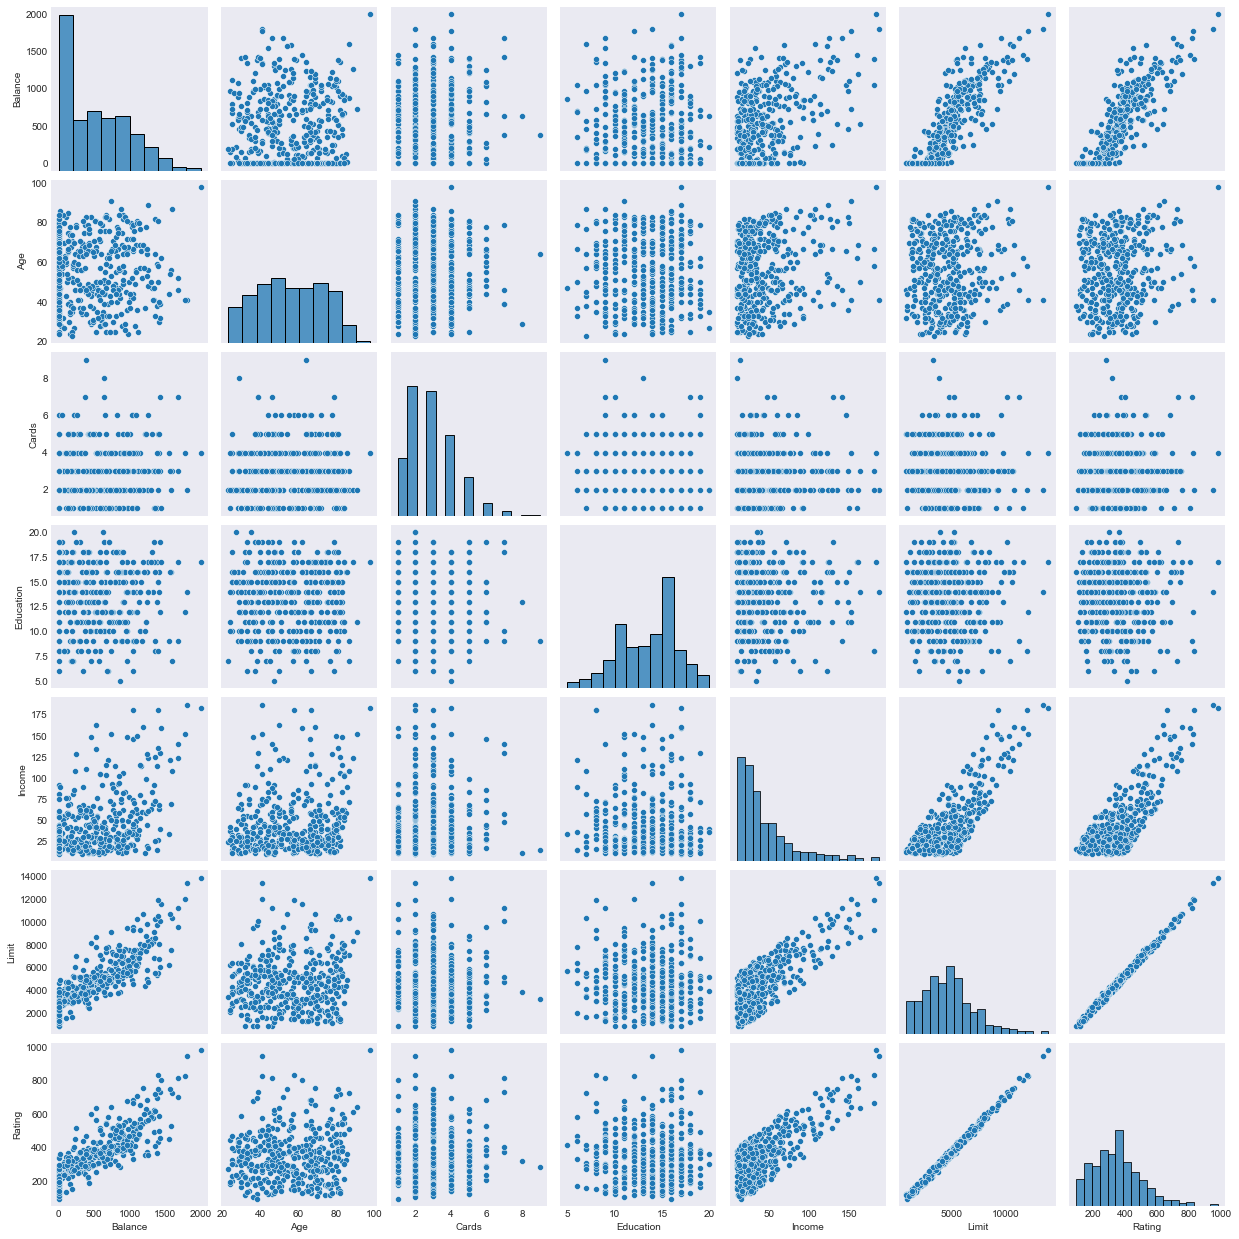

In [178]:
print("We have 4 qualitative variables: _gender_, _student_, _married_, _ethnicity_")

df = credit.copy()
display(df.head())
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']])

In [179]:
categorical_columns = [columns for columns in df.columns if 'Gender' in columns or 'Student' in columns or 'Married' in columns or 'Ethnicity' in columns]

# Number of categorical columns
print('Number of categorical columns: ', len(categorical_columns))

for columns in categorical_columns:
    print()
    print('The column is {} and it has {} unique value(s).'.format(columns, len(df[columns].unique())))
    display(pd.DataFrame(df[[columns]].value_counts(), columns = ['number_of_occurences']))

Number of categorical columns:  5

The column is Gender and it has 2 unique value(s).


,number_of_occurences
Gender,
Female,207
Male,193



The column is Student and it has 2 unique value(s).


,number_of_occurences
Student,
No,360
Yes,40



The column is Married and it has 2 unique value(s).


,number_of_occurences
Married,
Yes,245
No,155



The column is Ethnicity and it has 3 unique value(s).


,number_of_occurences
Ethnicity,
Caucasian,199
Asian,102
African American,99



The column is Student2 and it has 2 unique value(s).


,number_of_occurences
Student2,
0,360
1,40


###### Technique 1: 

```python
# these variables follow the same scale
def map_new_vals(colname, dictionary):
    df[colname] = df[colname].map(dictionary)
    
    
quality_dict =  {'Ex': 5,
                 'Gd': 4,
                 'TA': 3,
                 'Fa': 2,
                 'Po': 1,
                'None': 0}
    

map_new_vals('column_name', dictionary = quality_dict)
```

In [180]:
# 3 Ways to do it -->

def one_and_zero(x):
    if x == 'Yes':
        return 1
    else:
        return 0
    
for columns in df.loc[:, ['Student','Married']].columns: # get student and married columns
    df[columns] = df[columns].map(one_and_zero)

In [181]:
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,0,1,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,1,1,Asian,903,1
2,104.593,7075,514,4,71,11,Male,0,0,Asian,580,0
3,148.924,9504,681,3,36,11,Female,0,0,Asian,964,0
4,55.882,4897,357,2,68,16,Male,0,1,Caucasian,331,0


###### Technique 2

```python
df['Gender'] = test['Gender'].map(lambda x: 1 if x=='Female' else 0)
```

In [182]:
print(df["Gender"].head().values)
df["Gender"] = df["Gender"].str.replace(" ","") # Remove trailing spaces for "Male"

[' Male' 'Female' ' Male' 'Female' ' Male']


In [183]:
# extremely high over representation of AllPub but will be dealt it if the need arises
# for now, just assign numerical values
print(df['Gender'].value_counts())
df['Gender'] = df['Gender'].map({'Female':1,'Male':0})


Female    207
Male      193
Name: Gender, dtype: int64


###### Technique 3: One hot-encoding

Creates a column for each category

In [184]:
"""
Dropping your first categorical variable is possible because if every other dummy column is 0, 
then this means your first value would have been 1. What you remove in redundancy, you gain confusion.

Without dropping it would look like:
Ethnicity_AfricanAmerican | Ethnicity_Asian | Ethnicity_Caucasian
        0                 |        0        |         1
.....

"""

df = pd.get_dummies(df, columns=['Ethnicity'], drop_first=True)# Ensure to drop first to avoid redundant columns
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance,Student2,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,11,0,0,1,333,0,0,1
1,106.025,6645,483,3,82,15,1,1,1,903,1,1,0
2,104.593,7075,514,4,71,11,0,0,0,580,0,1,0
3,148.924,9504,681,3,36,11,1,0,0,964,0,1,0
4,55.882,4897,357,2,68,16,0,0,1,331,0,0,1


###### Qualitative Predictors with only two levels 1 and 0 (pg 84)
---
Suppose we wish to to investigate differences in credit card balances between Males and Females, ignoring other variables at the moment. We simply create a dummy variable that takes two levels. For example, based on the gender variable, we can create a new variable that takes the form $x_i = \{  \binom{1 if the ith person is female}{0 if the ith person is male}$.

Now, $\beta_0$ can be interepretated as the average credit balance among males, $\beta_0 + \beta_1$ as the average credit balance between females and males. For example, the table below shows that the average credit card debt for males is 509, whereas females are estimated to carry an additional debt of 19.73 compared to males (529 overall). However, the p-value for the dummy variable is high and thus there is no statistical evidence of a difference in average credit card balance between the two genders.

In [185]:

est = smf.ols('Balance ~ Gender', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,509.8031,33.128,15.389,0.000,444.675,574.931
Gender[T.Female],19.7331,46.051,0.429,0.669,-70.801,110.267


###### Qualitative Predictors with > two levels (pg 85)
---
There will always be one fewer dummy variable than the number of levels. The level with no dummy variable is known as the _baseline_.
Table shows that the basleline african american debt is 531 on average, and that asians on average will have 19 less debt than african american and finally, caucasians will have 12.50 less debt than african american. However, p-values associated with Asian and Caucasian are very large, suggesting no statistical evidence of a real difference in credit card balance betwen the ethnicities.

In [186]:
est = smf.ols('Balance ~ Ethnicity', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


**Predict Credit Balance**

In [189]:
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance,Student2,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,11,0,0,1,333,0,0,1
1,106.025,6645,483,3,82,15,1,1,1,903,1,1,0
2,104.593,7075,514,4,71,11,0,0,0,580,0,1,0
3,148.924,9504,681,3,36,11,1,0,0,964,0,1,0
4,55.882,4897,357,2,68,16,0,0,1,331,0,0,1


In [200]:
from sklearn.linear_model import LinearRegression

X = df[['Rating','Age','Education', 'Gender']]
y = df['Balance']

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
y_pred[:5] # Predicting Y based on Regression

array([ 370.9361248 ,  800.79259475,  883.14711367, 1411.90341314,
        496.57039794])

This plots regressions lines by category, whether male of female.

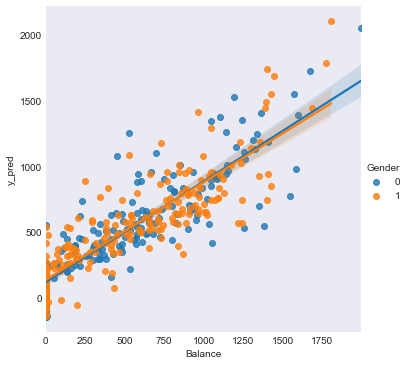

In [201]:
df['y_pred'] = y_pred
sns.lmplot(x='Balance', y='y_pred', data=df, hue='Gender',)

#### Normality:  Do the Residual Errors follow a normal distribution?

<AxesSubplot:xlabel='residuals', ylabel='Density'>

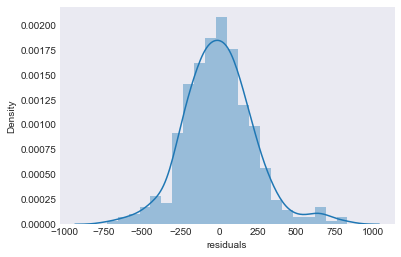

In [203]:
df['residuals'] = df['Balance'] - df['y_pred']
sns.distplot(df['residuals'])

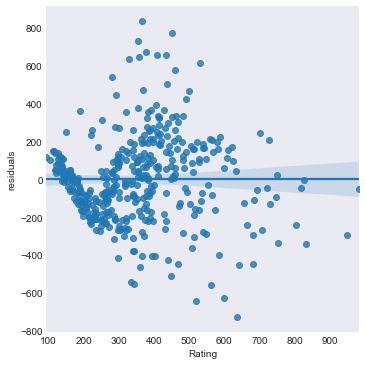

In [204]:
# Equality of variance. 

sns.lmplot(x='Rating', y='residuals', data=df)

#### 3.3.2 Extensions of the Linear Model
----
Many highly restrictive restrictions here. Two of the most important assumptions state that the relationship between predictors and response are (i) additive (ii) linear. Additive assumption means that the effect of changes in predictor $X_j$ on response $Y$ is independent of the value of the other predictors. Linear assumption states that change in response $Y$ due to a one-unit change in $X_j$ is constant regardless of the value of $X_j$.

###### 1. **Removing the Additive Assumption**
---

- Linear model states average effect on sales if a one unit increase in TV, regardless on amount spent on radio
- But if spending money on radio actually increases affect on TV, slope term for TV should increase as radio increase
- Hence, we need an interaction term!

The results suggests that the model that includes the interaction term is superior to the model that contains only the main effects. The p-value for the interaction term is superior than the model that only contains the main effects. The p-value for the interaction term TV x Radio is extremely low, indicating that there is a strong evidence for $h_0: \beta_3 \neq 0$. In other words, it is clear that the true relationship is not additive. An increase in advertising in TV of 1000, is associated with an increased sales of (19 + 1.1 * radio) units. The _hierarchical priciple_ states that if we include an interaction term in the model, we should also include the main effects, even if the p-values are not sigficant.

In [150]:
# 2 Quantitive Variables
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


The right-hand panel shows the estimated relationships between income and balance for students and non-students in the model. We note that the slope for students is lower than slope for non-students, suggesting that increases in income are associated with smaller increases in credit card balance among students compared to non-students.

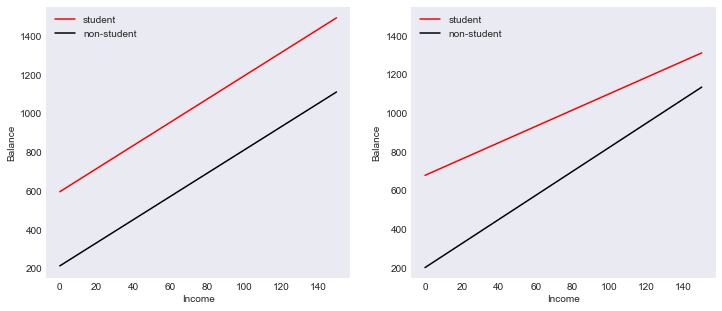

In [160]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+
                       150*(regr2['Income']+regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

In [151]:
# 1 Quantitative and 1 Qualitative
est1 = smf.ols('Balance ~ Income + Student2', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2 - with interaction term
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


###### 2. **Non-Linear Relationships**
---

- We assumed in the linear regression model that there is a linear relationship between predictors and response
- But the true relationship may be non-linear and thus we extend this further by using _polynomial regression_.
- Hence, we need an interaction term!

###### `PolynomialFeatures`
---

Congrats! We struck gold on our first interaction term. The question now is how do we create interaction terms **en masse**? In our small dataset, we have three interaction terms:

1. `TV * radio`
2. `TV * newspaper`
3. `radio * newspaper`

With larger datasets, manually creating interaction terms would quickly become untenable. That's where `sklearn`'s `PolynomialFeatures` comes in. `PolynomialFeatures` will return 9 columns from our original features matrix:

1. The original `TV` column
2. The original `radio` column
3. The original `newspaper` column
4. `TV^2` (`TV` squared)
5. `radio^2` (`radio` squared)
6. `TV^2` (`TV` squared)
7. `TV radio` interaction
8. `TV newspaper` interaction
9. `radio newspaper` interaction

In the cells provided, use `PolynomialFeatures` to transform `X`. **NOTE**: You'll need to set `include_bias=False`.

In [157]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
PolynomialFeatures()
features = ['TV', 'Radio', 'Newspaper']
X = advertising[features]
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)
X_poly.shape
poly.get_feature_names(features)
pd.DataFrame(X_poly, columns=poly.get_feature_names(features)).head()

,TV,Radio,Newspaper,TV^2,TV Radio,TV Newspaper,Radio^2,Radio Newspaper,Newspaper^2
0,230.1,37.8,69.2,52946.01,8697.78,15922.92,1428.84,2615.76,4788.64
1,44.5,39.3,45.1,1980.25,1748.85,2006.95,1544.49,1772.43,2034.01
2,17.2,45.9,69.3,295.84,789.48,1191.96,2106.81,3180.87,4802.49
3,151.5,41.3,58.5,22952.25,6256.95,8862.75,1705.69,2416.05,3422.25
4,180.8,10.8,58.4,32688.64,1952.64,10558.72,116.64,630.72,3410.56


In [159]:
# Use `cross_val_score` to see how much `PolynomialFeatures` affects the $R^2$ score.
cross_val_score(mlr, X_poly, y, cv=5).mean()

0.9842540981580093

The orange line represents the linear regression fit. There is a pronounced relationship between mpg and horsepower but it seems clear that in fact this relationship is non-linear. Data suggests a curved relationship. The quadradatic fit appears to be substantially better than the fit obtained when just the linear term is included. The green curve displays the fit that results from including all polynomials up to the fifth degree in the model. The resulting fit seems unneccessarily wiggly - that is, it is unclear that including the additional terms really has led to a better fit to the data.

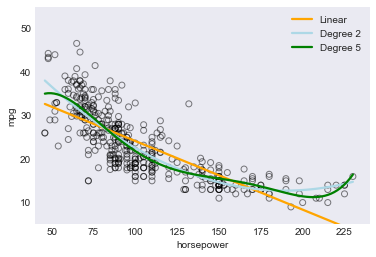

In [161]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto.horsepower, auto.mpg, facecolors='None', edgecolors='k', alpha=.5) 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

#### 3.3.3 Potential Problems
----
1. Non-Linearity of the Data
2. Correlation in the Error Terms
3. Non-constant Variance of Error Terms
4. Outliers
5. High Leverage Points
6. Collinearity